In [61]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)



class tf_model:
    def __init__(self,):
        pass
    
    def initialize_parameters(self):
        tf.set_random_seed(1)                  
        W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
        W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        b2 =tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer()) 
        W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        b3 = tf.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())
        parameters = {"W1": W1,
                      "b1": b1,
                      "W2": W2,
                      "b2": b2,
                      "W3": W3,
                      "b3": b3}
        return parameters
    
    def forward_propagation(self, X, parameters):
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        W3 = parameters['W3']
        b3 = parameters['b3']
        Z1 = tf.add(tf.matmul(W1,X), b1)                                              # Z1 = np.dot(W1, X) + b1
        A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
        Z2 = tf.add(tf.matmul(W2,A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
        A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
        Z3 = tf.add(tf.matmul(W3,A2), b3)  
        return Z3
    
    def compute_cost(self, Z3, Y):
        logits = tf.transpose(Z3)
        labels = tf.transpose(Y)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits =logits, labels = labels))
        return cost
    
    def random_mini_batches(self,X, Y, mini_batch_size = 64, seed = 0):
        m = X.shape[1]               
        mini_batches = []
        np.random.seed(seed)

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
            mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
            mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches

    
    def fit(self, X_train, Y_train,X_test,Y_test, learning_rate=0.0001, num_epochs=2000, minibatch_size=32, print_cost=True):
        ops.reset_default_graph()                         
        tf.set_random_seed(1)                             
        seed = 3                                          
        (n_x, m) = X_train.shape                          
        n_y = Y_train.shape[0]                            
        costs = []   
        
        X = tf.placeholder(tf.float32, [n_x,None], name='X')
        Y = tf.placeholder(tf.float32, [n_y,None], name='Y')
        
        parameters = self.initialize_parameters()
        
        Z3 = self.forward_propagation(X, parameters)
        
        cost = self.compute_cost(Z3, Y)
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            for epoch in range(num_epochs):
                epoch_cost = 0.                       
                num_minibatches = int(m / minibatch_size)
                seed = seed + 1
                minibatches = self.random_mini_batches(X_train, Y_train, minibatch_size, seed)
                for minibatch in minibatches:
                    (minibatch_X, minibatch_Y) = minibatch
                    _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                    epoch_cost += minibatch_cost / num_minibatches
                if print_cost == True and epoch % 100 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                if print_cost == True and epoch % 5 == 0:
                    costs.append(epoch_cost)

            # plot the cost
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

            self.parameters = sess.run(parameters)
            print ("Parameters have been trained!")

            # Calculate the correct predictions
            correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

            # Calculate accuracy on the test set
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

            print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
            print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))



    def predict(self, X):
        W1 = tf.convert_to_tensor(self.parameters["W1"])
        b1 = tf.convert_to_tensor(self.parameters["b1"])
        W2 = tf.convert_to_tensor(self.parameters["W2"])
        b2 = tf.convert_to_tensor(self.parameters["b2"])
        W3 = tf.convert_to_tensor(self.parameters["W3"])
        b3 = tf.convert_to_tensor(self.parameters["b3"])
        params = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
        x = tf.placeholder("float", [12288, 1])
        z3 = self.forward_propagation(x, params)
        p = tf.argmax(z3)
        with tf.Session() as sess:
            prediction = sess.run(p, feed_dict = {x: X})
        return prediction


In [62]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [63]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [64]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)


Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016411
Cost after epoch 200: 0.733256
Cost after epoch 300: 0.572957
Cost after epoch 400: 0.468875
Cost after epoch 500: 0.381083
Cost after epoch 600: 0.313972
Cost after epoch 700: 0.254411
Cost after epoch 800: 0.203953
Cost after epoch 900: 0.166660
Cost after epoch 1000: 0.142506
Cost after epoch 1100: 0.107757
Cost after epoch 1200: 0.086087
Cost after epoch 1300: 0.060919
Cost after epoch 1400: 0.051012
Cost after epoch 1500: 0.035880
Cost after epoch 1600: 0.025462
Cost after epoch 1700: 0.022334
Cost after epoch 1800: 0.015468
Cost after epoch 1900: 0.010475
Cost after epoch 2000: 0.005691
Cost after epoch 2100: 0.007177
Cost after epoch 2200: 0.003458
Cost after epoch 2300: 0.002584
Cost after epoch 2400: 0.002157
Cost after epoch 2500: 0.001707
Cost after epoch 2600: 0.001419
Cost after epoch 2700: 0.001175
Cost after epoch 2800: 0.001548
Cost after epoch 2900: 0.000836
Cost after epoch 3000: 0.000734
Cost after epoch 310

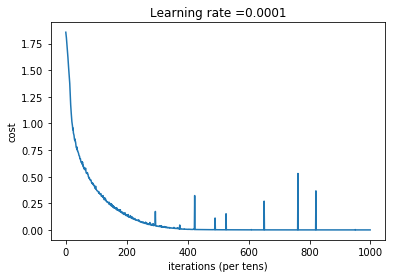

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.7583333


In [51]:
clf = tf_model()
clf.fit(X_train,Y_train,X_test,Y_test,num_epochs=5000)

In [52]:
import pickle
with open('tf_nn.pkl', 'wb') as f:
        pickle.dump(clf, f)

In [53]:
import pickle
with open('tf_nn.pkl', 'rb') as f:
    clf1 = pickle.load(f)

/home/shangeth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/shangeth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


Your algorithm predicts: y = 2


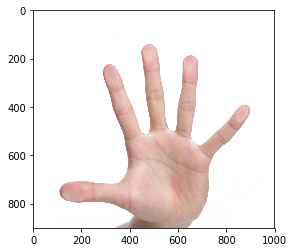

In [60]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "i5.jpeg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = clf1.predict(my_image)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))
